In [1]:
library(igraph)
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(compiler)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::si

In [2]:
survived <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(V(g)$load, decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived <- cmpfun(survived)

In [3]:
survived_deg <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(degree(g), decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_deg <- cmpfun(survived_deg)

In [4]:
survived_random <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- sample(x = 1:length(g), size = 1)

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_random <- cmpfun(survived_random)

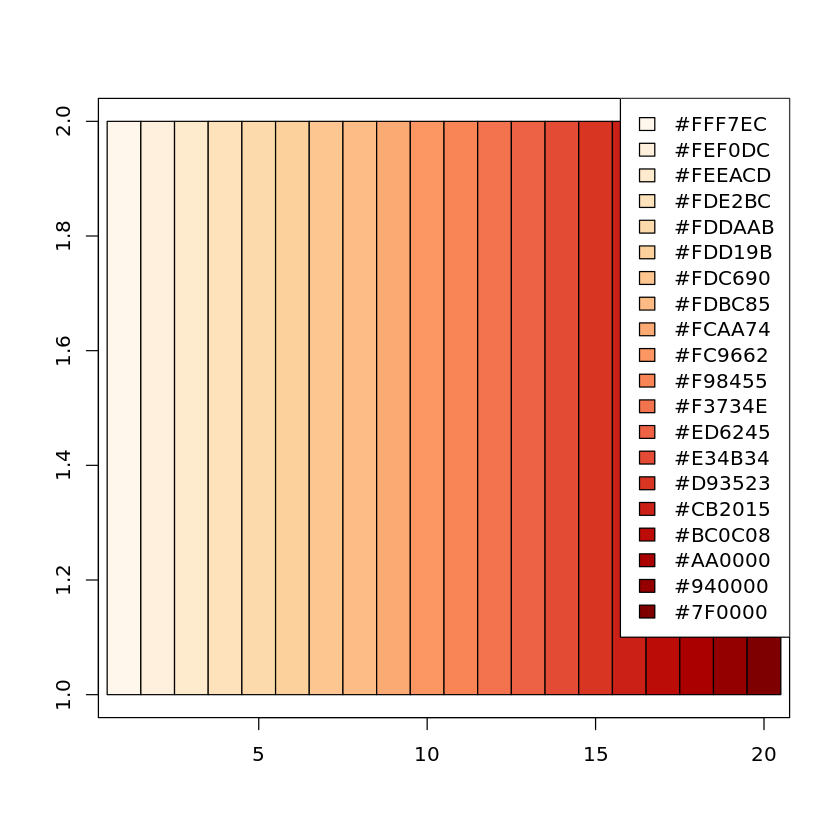

In [5]:
mypal <- rev(colorRampPalette(rev(c(brewer.pal(9, "OrRd"))))(20))
plot(1, 1, type = "n", xlim = c(1, length(mypal)), ylim = c(1, 2), xlab = "", ylab = "")
for (i in 1:length(mypal)) {
  rect(i - 0.5, 1, i + 0.5, 2, col = mypal[i])
}
legend("topright", legend = mypal, fill = mypal, bg = "white")

In [6]:
# mypal

In [7]:
nodes<-read.csv('power/nodes_clean.csv')
edges<-read.csv('power/edges.csv')

In [8]:
layout<-as.matrix(nodes,rownames.force = F)
layout <- layout.norm(layout, -1, 1, -1, 1)

In [9]:
el<-as.matrix(edges+1)
g<-graph_from_edgelist(el = el, directed = FALSE)

In [10]:
btw<-betweenness(g, normalized=FALSE,  directed = F)

In [11]:
index <- which.max(btw)

In [12]:
btw_log <- log(1+btw)

In [13]:
# normalize and convert to integer between 1 and 20
btw_col_idx <- 1 + floor((19)*(btw_log - min(btw_log))/(max(btw_log)-min(btw_log)))

In [14]:
colors<-mypal[btw_col_idx]

In [15]:
# mypal[bet][3782]<-'#0000FF'

In [16]:
pdf("power/whole_graph.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
#      xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()
rect(xleft = 0.2, xright = 0.8, ytop = 0.7, ybottom = 0.1, lwd = 2)
rect(xleft = 0.5, xright = 1, ybottom = -0.6, ytop =-0.1, lwd = 2)


plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Node of highest btw',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(0.2,0.8),
     ylim = c(0.1, 0.7),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T, main='Zoom on detail',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(0.5,1),
     ylim = c(-0.6, -0.1),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
grid()
dev.off()

png 
  2

In [17]:
deg_graph<-degree(g)

In [18]:
fit_res<-fit_power_law(deg_graph, xmin = 1)

In [19]:
fit_res

$continuous
[1] FALSE

$alpha
[1] 1.795673

$xmin
[1] 1

$logLik
[1] -10258.33

$KS.stat
[1] 0.2813235

$KS.p
[1] 0

In [20]:
f <- function(g, x) {
    function(x) {
        x^-g
    }
}

In [21]:
f2<-f(2)
f3<-f(3)
f_c<-f(fit_res$alpha)

In [22]:
deg_dist<-degree_distribution(g)

In [23]:
fitting_df <- data.frame(k = 1:19, p = ifelse(is.finite(log(deg_dist)[2:20]), log(deg_dist)[2:20],
    NA))

In [24]:

linear_model <- lm(p ~ k, data=fitting_df)

In [25]:
p_not_log_grid <- data.frame(x = (min(degree(g)) - 1):max(degree(g)), y = ifelse(degree_distribution(g) ==
    0, NA, degree_distribution(g)))

mod <- lm(log(y) ~ log(x), data = p_not_log_grid)
pwr <- function(x) exp(predict(mod, newdata = data.frame(x = x)))
pwr3<-function(x){return(100*x^(-3))}
pwr2<-function(x){return(10*x^(-2))}

In [26]:
nodes_in <- read.csv("internet/nodes_clean.csv")
edges_in <- read.csv("internet/edges.csv")

el_in <- as.matrix(edges_in + 1)
g_in <- graph_from_edgelist(el = el_in, directed = FALSE)

p_not_log_int <- data.frame(x = (min(degree(g_in)) - 1):max(degree(g_in)), y = ifelse(degree_distribution(g_in) ==
    0, NA, degree_distribution(g_in)))

mod_int <- lm(log(y) ~ log(x), data = p_not_log_int)
pwr_int <- function(x) exp(predict(mod_int, newdata = data.frame(x = x)))
pwr3 <- function(x) {
    return(x^(-3))
}

In [27]:
p_not_log_grid['net']<-'US grid'
p_not_log_int['net']<-'Internet'

p_not_log_all<-rbind(p_not_log_grid, p_not_log_int)

Warning message in stat_function(fun = pwr2, color = "#FF0000", linewidth = 1, ylim = c(-3, :
“Ignoring unknown parameters: `ylim`”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1394 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 51 rows containing missing values (`geom_function()`).”
Warning message:
“Removed 44 rows containing missing values (`geom_function()`).”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1394 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 51 rows containing missing values (`geom_function()`).”
Warning message:
“Removed 44 rows containing missing values (`geom_function()`).”
Warning message in is.na(x):
“

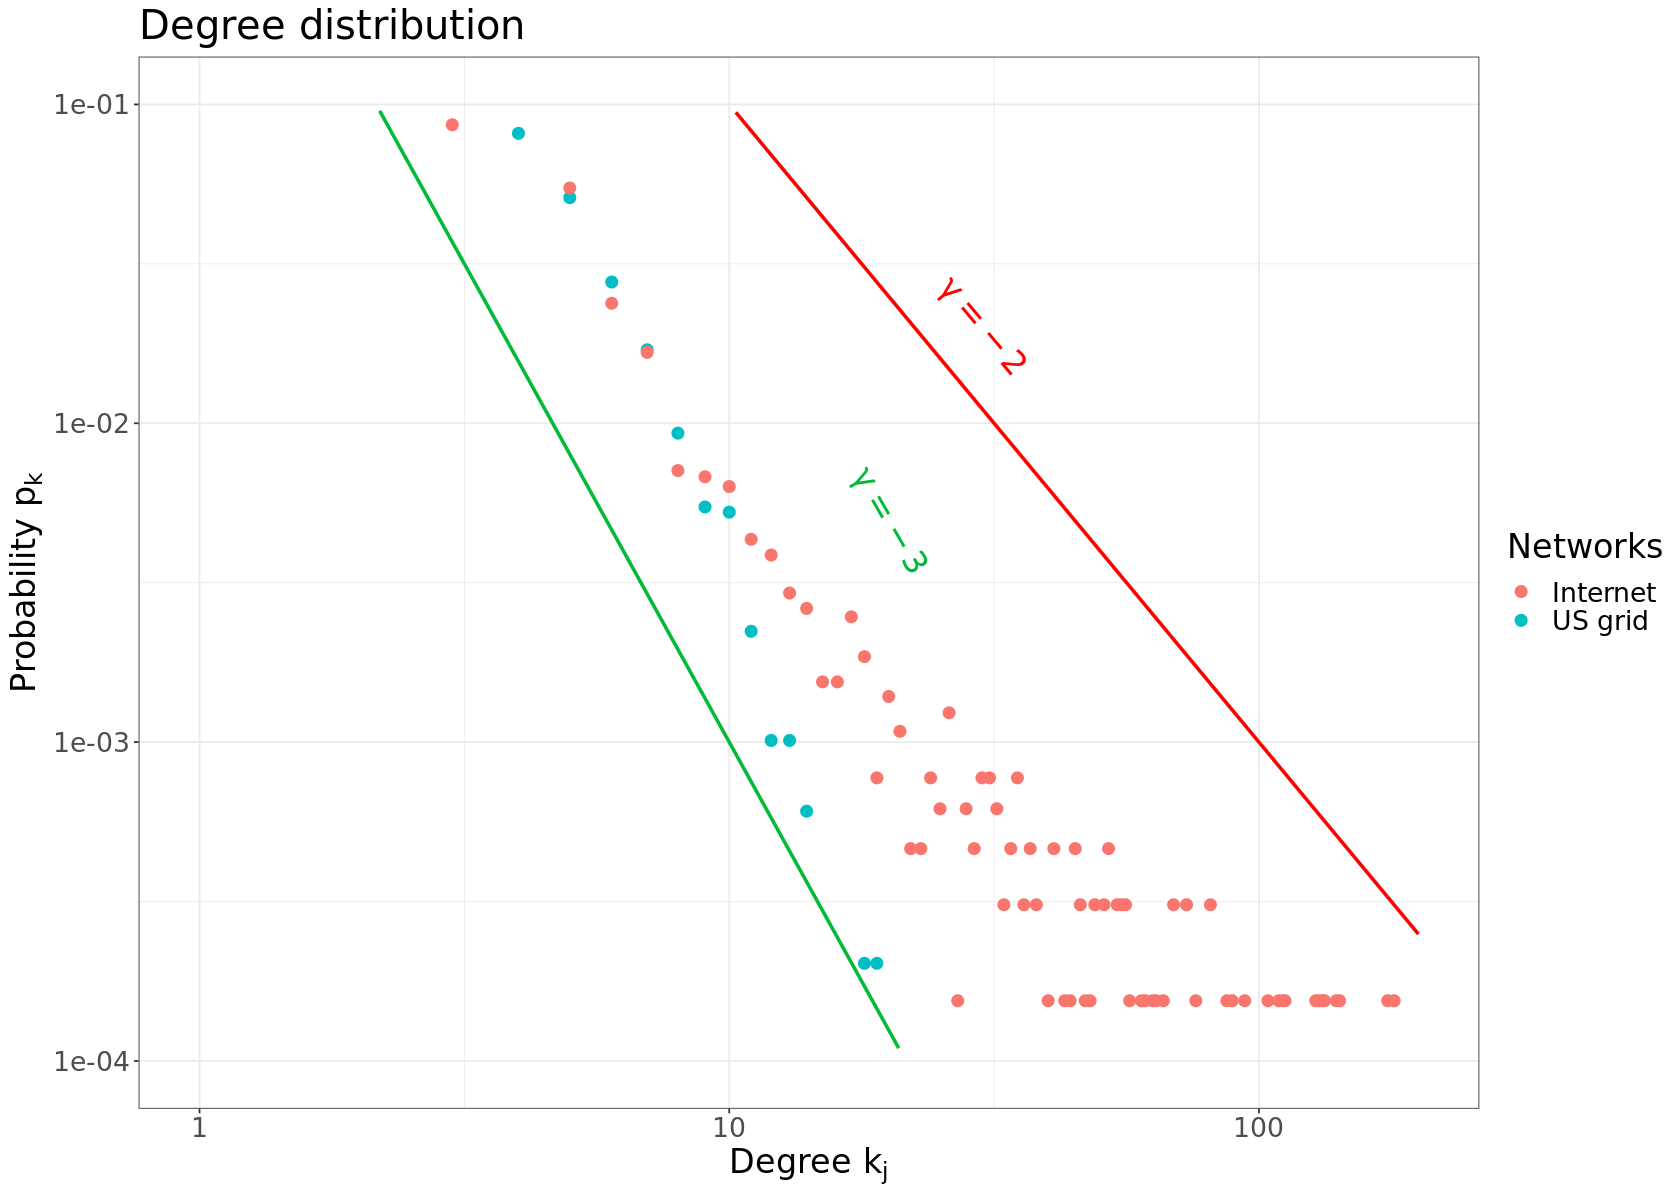

In [28]:
plot_deg_dist_all<-ggplot(p_not_log_all) + geom_point(aes(x = x, y = y, col = net), size = 3) +
scale_x_log10(limits=c(1, 200)) +
scale_y_log10(limits=c(1e-4, 1e-1)) +
theme_bw() + 
theme(text = element_text(size = 20)) + 
labs(title = "Degree distribution",
     x = expression(paste("Degree ", k[j])),
     y = expression(paste("Probability ", p[k])),
     col = "Networks") +
# stat_function(fun = pwr,
#               color = "#F8766D",
#               linewidth = 1,
#               xlim = c(0, log10(30))) +
stat_function(fun = pwr3,
              color = "#00BA38",
              linewidth = 1,
              xlim = c(0, 2))+
stat_function(fun = pwr2,
              color = "#FF0000",
              linewidth = 1,
              ylim = c(-3, -1))+
annotate(geom = "text",
         x = 20,
         y = 4.9e-3,
         label = expression(gamma == -3),
         color = "#00BA38",
         size = 7,
         angle = -60)+
annotate(geom = "text",
         x = 30,
         y = 2e-2,
         label = expression(gamma == -2),
         color = "#FF0000",
         size = 7,
         angle = -50)

plot_deg_dist_all

ggsave(plot = plot_deg_dist_all, filename = 'internet/plot_deg_dist_all.pdf', width = 10, height = 7,
    scale = 0.75)

In [29]:
# pwr_law_fit_plot_grid <- ggplot(p_not_log_grid) + geom_point(aes(x = x, y = y), show.legend = TRUE,
#     size = 2) + theme_bw() + scale_y_log10() + scale_x_log10() + theme(text = element_text(size = 20)) +
#     labs(title = "Degree distribution on Internet network", x = expression(paste("Degree ",
#         group(langle, k, rangle))), y = expression(paste("Probability ", p[k]))) +
#     stat_function(fun = pwr, color = "#F8766D", linewidth = 1, xlim = c(0, log10(30))) +
#     stat_function(fun = pwr3, color = "#00BA38", linewidth = 1, xlim = c(0, log10(30))) +
#     annotate(geom = "text", x = 2.5, y = 0.01, label = expression(paste("Fit: ",
#         gamma, "=-2.8")), color = "#F8766D", size = 7, angle = -30) + annotate(geom = "text",
#     x = 10, y = 1e-3/4, label = expression(paste("Typical: ", gamma, "=-3")), color = "#00BA38",
#     size = 7, angle = -58)+geom_point(data=p_not_log_int, aes(x = x, y = y), size = 2, color='red')


# pwr_law_fit_plot_grid

In [30]:
# pwr_law_fit_plot <- ggplot(p_not_log_int) + geom_point(aes(x = x, y = y), size = 2) +
#     theme_bw() + scale_y_log10() + scale_x_log10() + theme(text = element_text(size = 20)) +
#     labs(title = "Degree distribution on Internet network", x = expression(paste("Degree ",
#         group(langle, k, rangle))), y = expression(paste("Probability ", p[k]))) +
#     stat_function(fun = pwr_int, color = "#F8766D", linewidth = 1, xlim = c(0, 2)) +
#     stat_function(fun = pwr3, color = "#00BA38", linewidth = 1, xlim = c(0, log10(30))) +
#     annotate(geom = "text", x = 2.5, y = 0.01, label = expression(paste("Fit: ",
#         gamma, "=-1.2")), color = "#F8766D", size = 7, angle = -30) + annotate(geom = "text",
#     x = 10, y = 0.001/4, label = expression(paste("Typical: ", gamma, "=-3")), color = "#00BA38",
#     size = 7, angle = -58)


# pwr_law_fit_plot

# # ggsave(plot = pwr_law_fit_plot, filename = "internet/pwr_law_fit.pdf", width = 10,
# #     height = 7, scale = 0.75)

In [31]:
# # pdf("power/deg_distrib.pdf",width=14, height = 10) 

# layout.matrix <- matrix(c(1, 1, 1, 1, 2, 0), nrow = 2, ncol = 3)
# lay_plots <- layout(mat = layout.matrix)


# x_min <- 1
# x_max <- 100
# # options(repr.plot.width = 14, repr.plot.height = 7)
# par(cex.axis = 1.5, cex.lab = 2, cex.main = 1, oma=c(2,2,2,2))
# plot(1:19, deg_dist[2:20], xlab = "Degree k", ylab = "Prob(k)", pch = 16, cex = 2.3,
#     xlim = c(1, 30), log = "xy")
# curve(f_c, from = x_min, to = x_max, add = T, log = "xy", col = "red", lwd = 3)
# curve(f2, from = x_min, to = x_max, add = T, log = "xy", col = "blue", lwd = 3)
# curve(f3, from = x_min, to = x_max, add = T, log = "xy", col = "darkgreen", lwd = 3)
# grid()
# legend("bottomleft", legend = c(paste("Fit pwr law:", round(fit_res$alpha,2)), "gamma=2", "gamma=3"), col = c("red",
#     "blue", "darkgreen"), lty = 1, lwd = 3, cex = 2)

# plot(1:19, log(deg_dist[2:20]), xlab = "Degree k", ylab = "log(prob(k))", pch = 16,
#     cex = 1.3, xlim = c(1, 22))
# abline(a = linear_model$coefficients[[1]], b = linear_model$coefficients[[2]])
# grid()
# legend('topright', legend=c('Linear model'), lwd=2, lty=1, cex=2)
# # dev.off()

In [32]:
betwe_in<-betweenness(g_in, normalized=FALSE)

In [33]:
betwe_df_in<-data.frame(x=betwe_in)

In [34]:
betwe<-betweenness(g, normalized=FALSE)

In [35]:
betwe_df<-data.frame(x=betwe)

In [36]:
betwe_df_in['net']<-'Internet'
betwe_df['net']<-'US grid'
betwe_df_all<-rbind(betwe_df_in, betwe_df)

Warning message:
“`stat(density)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 5129 rows containing non-finite values (`stat_density()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 5129 rows containing non-finite values (`stat_density()`).”


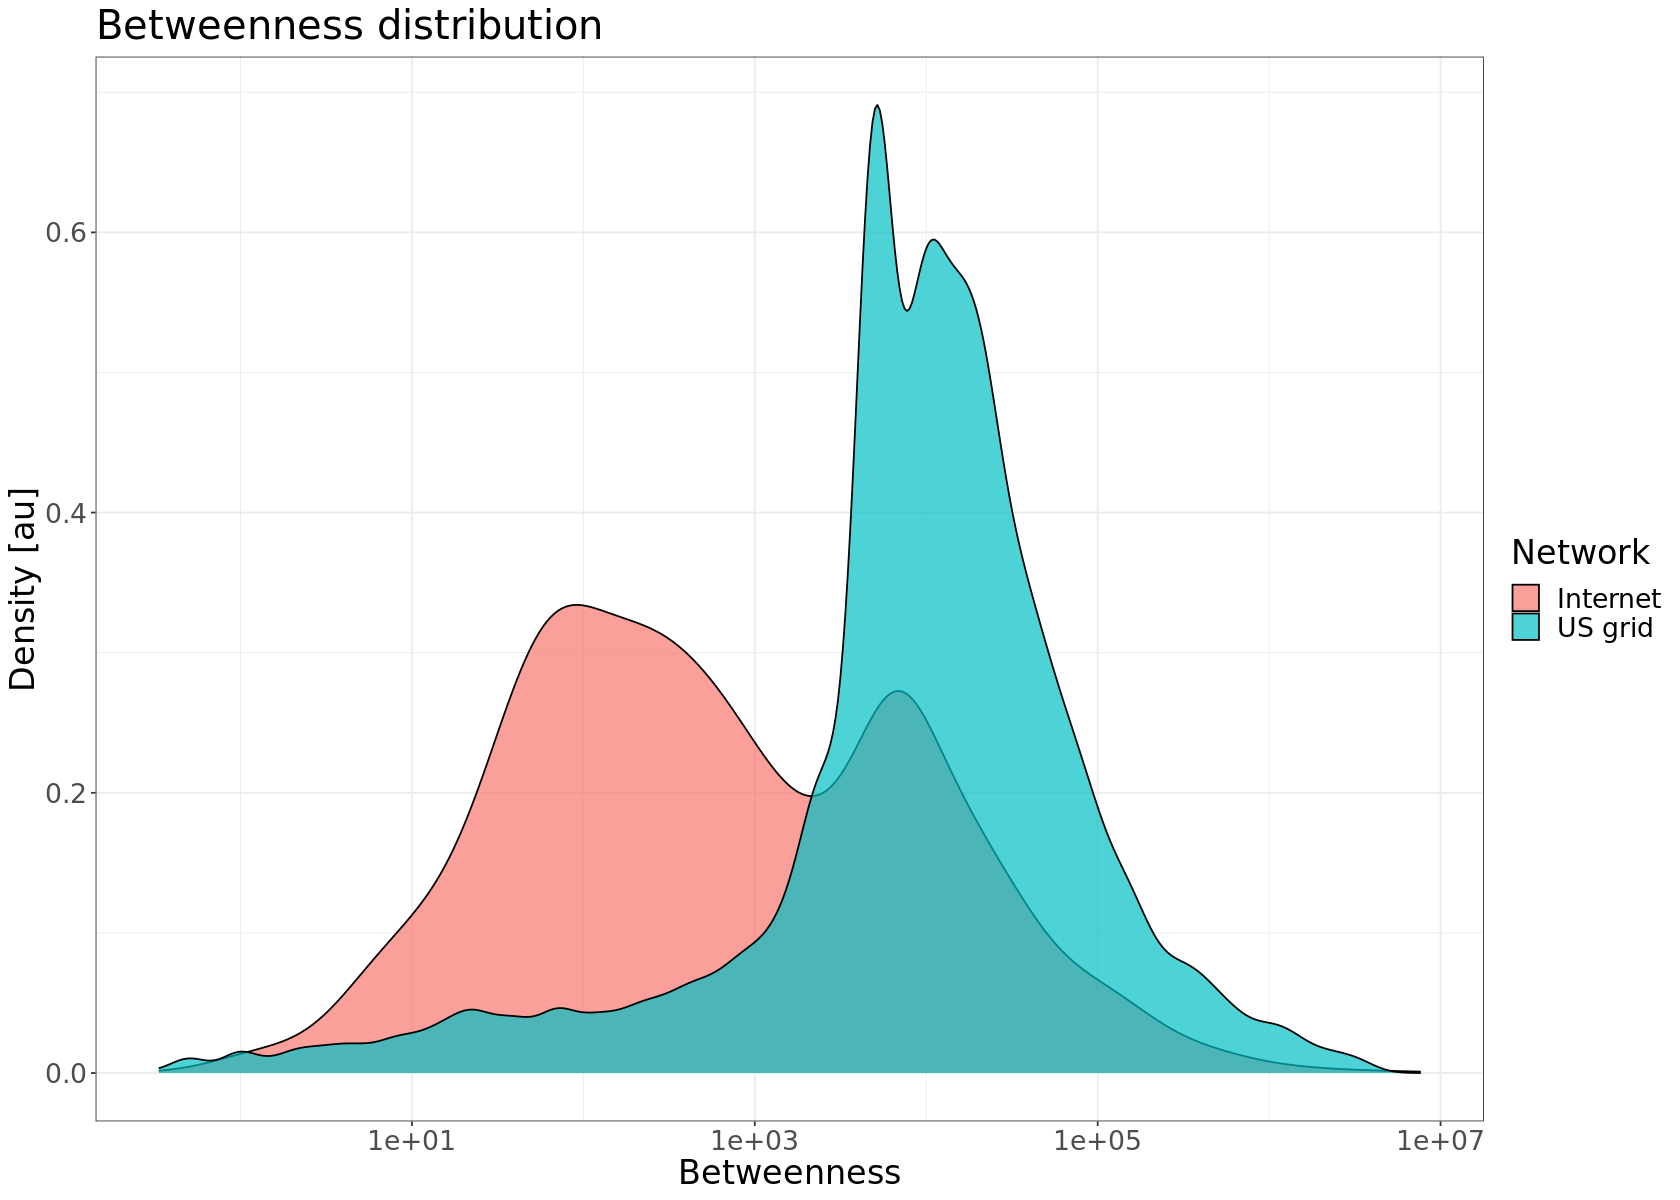

In [37]:
betw_plot_all<-ggplot(betwe_df_all) +
geom_density(aes(x = x, y = stat(density),  fill = net), alpha=0.7) +
scale_x_log10() +
theme_bw() +theme(text = element_text(size = 20)) +
theme(text = element_text(size = 20)) +
labs(x = "Betweenness",
     y = "Density [au]",
     title = "Betweenness distribution",
    fill='Network')

betw_plot_all

ggsave(plot = betw_plot_all, filename = 'power/betweenness_plot_all.pdf', width=10, height = 7, scale = 0.75)

In [38]:
# # pdf("power/betwe_distrib.pdf",width=7, height = 7) 

# par(mar = c(5, 4, 4, 4) + 0.3)
# h <- hist(log(betwe), breaks = 18, probability = T, xlab = "Log(btw)", ylab = "P(log(btw))",
#     main = "Betweenness distribution", col = "orange", )
# par(new = TRUE)
# h$counts <- cumsum(h$counts)/sum(h$counts)
# plot(h, axes = FALSE, xlab = "", ylab = "", main='', density = 90, col=alpha('blue',0.3) )
# axis(side = 4, at = pretty(c(0, 1)))
# mtext("Cumulative P(log(btw))", side = 4, line = 3)
# grid()
# # dev.off()

# analysis of tear down at different alpha
refer to script

In [39]:
# alphas <- seq(from = 0, to = 5, by = 0.5)

# g_ratio <- vector()
# g_ratio_deg <- vector()
# g_ratio_random <- vector()
# for (i in seq_along(alphas)) {
#     g_ratio[i] <- survived(g, alpha = alphas[i])
#     g_ratio_deg[i] <- survived_deg(g, alpha = alphas[i])
#     g_ratio_random[i] <- survived_random(g, alpha = alphas[i])
# }

# alphas_zoom <- seq(from = 0.1, to = 1.5, by = 0.1)

# g_ratio_zoom <- vector()
# g_ratio_deg_zoom<-vector()
# g_ratio_random_zoom<-vector()
# for (i in seq_along(alphas_zoom)) {
#     g_ratio_zoom[i] <- survived(g, alpha = alphas_zoom[i])
#     g_ratio_deg_zoom[i]<- survived_deg(g, alpha=alphas_zoom[i])
#     g_ratio_random_zoom[i] <- survived_random(g, alpha = alphas_zoom[i])

# }

# plot(alphas, g_ratio)
# plot(alphas, g_ratio_random, add=T, col='red')

# g_ratio_zoom

# plot(alphas_zoom, g_ratio_zoom)
# plot(alphas_zoom, g_ratio_random_zoom, col='red')

In [40]:
g_ratios<-read.csv('power/destroy_power_complete.csv')

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 15 rows containing missing values (`geom_segment()`).”


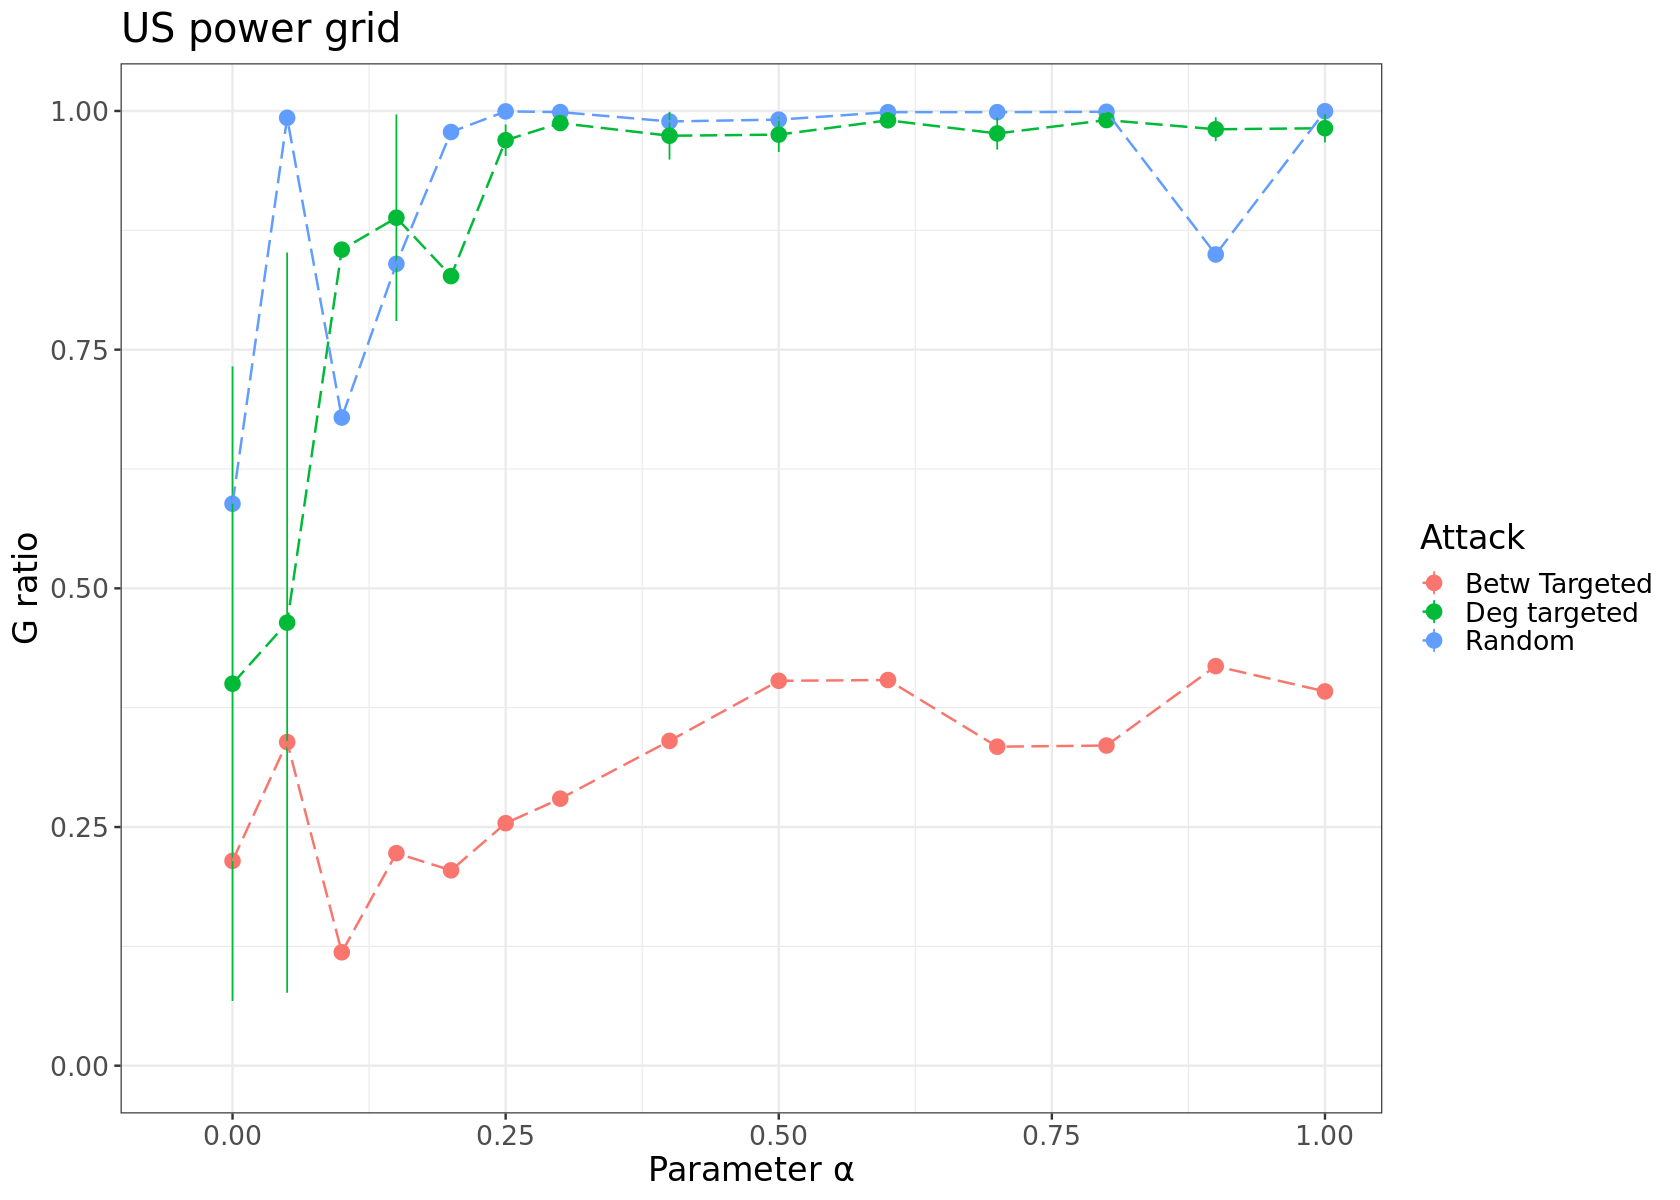

In [84]:
plot_conf_grd <- ggplot(g_ratios) +
geom_point(aes(x = alpha,
               y = g_ratio,
               col = type),
           size = 4) +
geom_linerange(aes(x = alpha,
                   ymax = g_ratio + g_ratio_sd,
                   ymin = g_ratio - g_ratio_sd,
                   col = type),
               position = position_dodge(-0.02)) +
geom_line(aes(x = alpha,
              y = g_ratio,
              col = type),
          linewidth = 0.7,
          linetype=5) +
scale_x_continuous(limits = c(-0.05, 1)) +
labs(x = expression(paste("Parameter ", alpha)), 
     y = "G ratio",
     col = "Attack", title='US power grid') +
ylim(0, 1) +
theme_bw(base_size = 15) +
theme( text = element_text(size = 20))


plot_conf_grd

# ggsave(plot = plot_conf_grd, filename = 'power/plot_g.pdf', width = 10, height = 7,
#     scale = 0.75)

In [42]:
# g_ratios %>% filter(type=='Betw Targeted') -> g_ratios_2

# plot_conf_2 <- ggplot(g_ratios_2) + geom_point(aes(x = alpha, y = g_ratio, col = type),
#     shape = 16, size = 3) + geom_linerange(aes(x = alpha, ymax = g_ratio + g_ratio_sd,
#     ymin = g_ratio - g_ratio_sd, col = type), position = position_dodge(-0.02)) +
#     geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1) + scale_x_continuous(limits = c(-0.05,
#     5)) + labs(x = expression(paste("Parameter ", alpha)), y = "Fraction of nodes G",
#     col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
#     0.6), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

# plot_conf_2

In [43]:
# ggsave(plot = plot_conf_2, filename = 'power/plot_g_targeted_only.pdf', width = 7, height = 5)

# select alpha and show destruction

In [44]:
alpha<-1

In [45]:
V(g)$cst_ids<-1:length(g)

# V(g)[index]$cst_ids

V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

# overloaded

dead_nodes<-overloaded

g_or <- g

In [46]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [47]:
# hist(log(V(g_or)$load), breaks = 20)

In [48]:
orig_idx<-V(g_or)[overloaded]$cst_ids

In [49]:
orig_idx

[1]   33   47   48  117  130  481  494  505  527  533  534  543  551  554  555
[16]  556  559  563  565  574 2557 2622 3783 3791 3813 3823 3871 3878 3898 3910
[31] 3912 3914 4094 4100 4102 4111 4112 4113 4116 4122 4133 4134 4145 4146 4147
[46] 4150 4157 4173 4174 4188 4189 4195 4202 4203 4212 4219 4222 4228 4318

In [50]:
dead_nodes<-c(dead_nodes, orig_idx)

In [51]:
colors<-mypal[btw_col_idx]

colors[orig_idx]<-'#5765ff'
colors[-orig_idx]<-'#f7be60'
colors[index]<-'red'

pdf("power/whole_graph_failing.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<-0.15
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<-0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, vertex.size = 2,  vertex.frame.color = 'grey50', vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
#      xaxt = NA, yaxt = NA,
#      xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
          main=expression(paste(alpha==1)),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes))), bg='white', cex=3)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = 'grey50', vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = 'grey50', vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0,
     axes = T, main='Zoom on first failed node',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2,y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

In [52]:
distances(graph = g, v = index)

12,18,22,26,9,11,7,7,6,5,⋯,26,22,22,21,23,23,24,22,23,22


In [53]:
first_faling<-data.frame(d=as.vector(distances(graph = g, v = index, to = orig_idx)))
distances_from_failing_node<-data.frame(d=as.vector(distances(graph = g, v = index)))

In [54]:
distances_from_failing_node['type']<-'between 1st and any node'
first_faling['type']<-'between 1st and 2nd failed nodes'
dst_all<-rbind(distances_from_failing_node, first_faling)

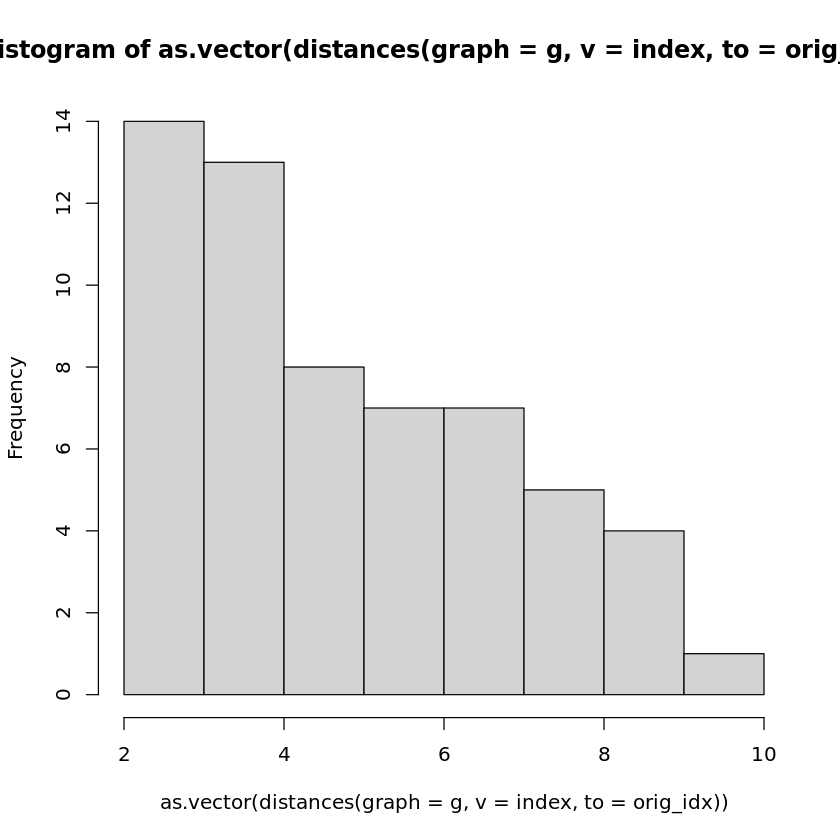

In [55]:
options(repr.plot.width=7, repr.plot.height=7)
h<-hist(as.vector(distances(graph = g, v = index, to = orig_idx)))

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


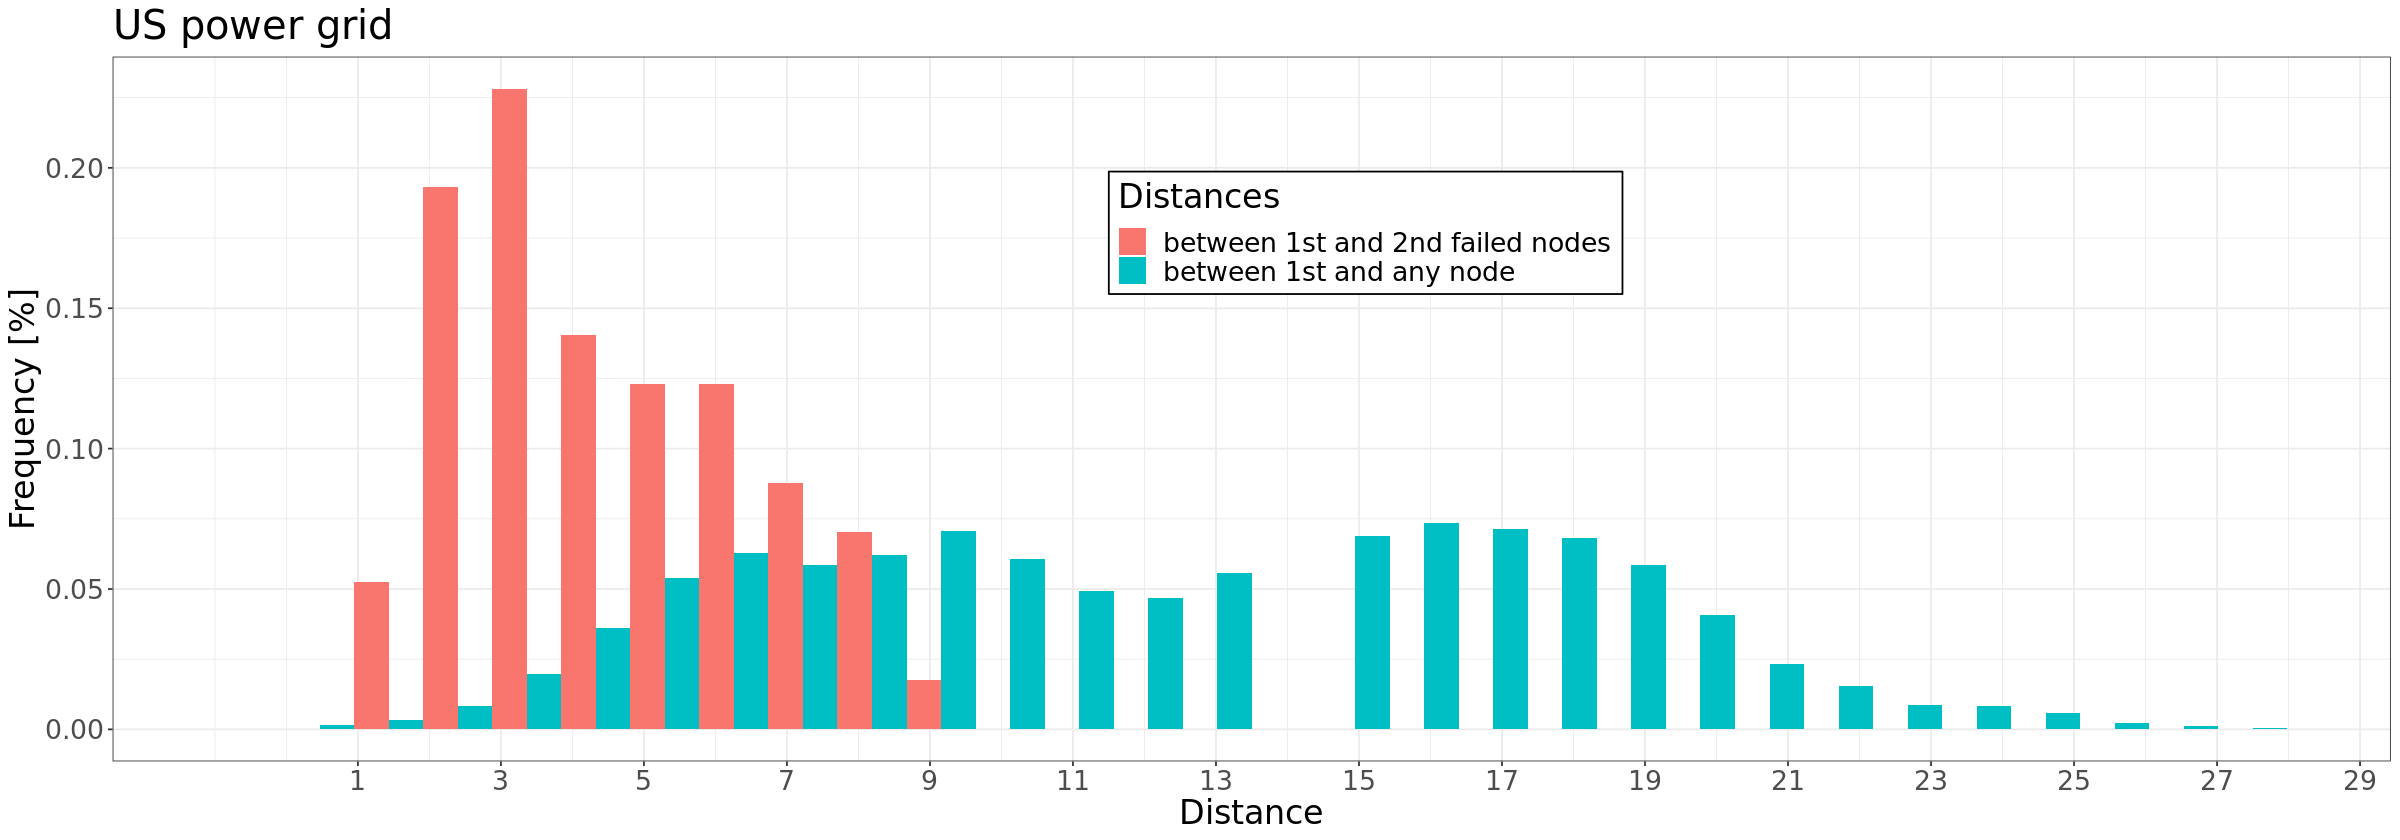

In [56]:
options(repr.plot.width = 20, repr.plot.height = 7)

plt_dst_all<-ggplot(dst_all) +
geom_histogram(aes(x = d,
                   y = ..density..,
                   fill = type),
               position = position_dodge()) +
labs(x = "Distance", 
     y = "Frequency [%]",
     title = "US power grid",
     fill = "Distances") +
theme_bw() +
theme(text = element_text(size = 20)) + 
theme(legend.position = c(0.55, 0.75),
      legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black")) +
scale_x_continuous(breaks = seq(1.5,30.5, 2),
                   labels = seq(1,30, 2))
plt_dst_all
ggsave(plot = plt_dst_all, filename = 'power/dst_all_first_failed.pdf', width = 10, height = 7,
    scale = 0.75)

In [57]:
pdf("power/distance_first_failed.pdf",width=7, height = 7)
par(cex.lab = 1.5, oma=c(2,2,2,2))
bp<-barplot(h$density, names.arg =min(h$breaks):(max(h$breaks)-1), xlab = "Distance from first failed node",
    ylab = "Frequency [%]", main='', col='orange', ylim=c(0,0.3))
text(bp, h$density + 0.02,paste('#:',h$counts))
grid()
dev.off()

png 
  2

In [58]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [59]:
orig_idx<-V(g_or)[overloaded]$cst_ids

In [60]:
orig_idx

[1]   12   32   41   56   58   60   61   72   74   78   82   83   87   92   99
 [16]  107  121  126  132  137  140  141  142  148  151  157  174  182  186  191
 [31]  192  201  223  226  385  394  428  448  483  484  485  486  496  497  498
 [46]  499  500  522  523  536  537  539  550  560  693  727  838  839  840  841
 [61]  845  846  853  854  866  874  875  883  884  885  886  893  894  901  931
 [76]  932 1126 1477 2224 2236 2263 2299 2343 2344 2345 2352 2365 2563 3762 3768
 [91] 3770 3788 3802 3826 3852 3856 3872 3884 3911 3916 3950 3999 4027 4036 4051
[106] 4087 4091 4161 4218 4447 4449 4459 4462

In [61]:
dead_nodes<-c(dead_nodes, orig_idx)

In [62]:
colors[dead_nodes]<-'#0000FF'
colors[-dead_nodes]<-'#c6c6c6'
colors[index]<-'#FF0000'

In [63]:
pdf("power/whole_graph_failing_2.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<--0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = NA, vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
#      xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
          main=expression(paste(alpha==1)),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, -0.8, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes))), bg='white', cex=3)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0, edge.color='black',
     axes = T, main='Zoom on first failed node',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

In [64]:
V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

dead_nodes<-overloaded
g_or <- g

counts<-0
while (length(overloaded) > 0) {
    g_or <- delete_vertices(g_or, overloaded)
    V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
    overloaded <- as.vector(V(g_or)[load > capacity])
    orig_idx<-V(g_or)[overloaded]$cst_ids
    dead_nodes<-c(dead_nodes, orig_idx)
    counts<-counts+1
}


n_prime <- max(components(g_or)$csize)
n_orig <- max(components(g)$csize)

# return(n_prime/n_orig)

In [65]:
biggest_cluster_id <- which.max(components(g_or)$csize)

# ids
vert_ids <- V(g_or)[components(g_or)$membership == biggest_cluster_id]

llc_id<-V(g_or)[vert_ids]$cst_ids

In [66]:
colors[dead_nodes]<-'#5765ff'
colors[-dead_nodes]<-'#f7be60'
colors[index]<-'red'
colors[llc_id]<-'#11d417'


In [67]:
pdf("power/whole_graph_failing_all.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<--0.2
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<--0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, vertex.size = 2, vertex.frame.color =alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,
#      xlab='x dimension [au]', ylab='y dimension [au]',
#      xlim = c(0.2,0.8),
#      ylim = c(0.2, 0.6),
          main=expression(paste(alpha==1)),
     rescale=F )
points(layout[index,1], layout[index,2], lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
# text(-1,1, paste('Affected region:', length(dead_nodes), 'nodes'), cex = 2, pos=4)
legend(-1, 1, legend = c(paste("Degree of first failed:", degree(g)[index]),
                            paste("Affected nodes:",length(dead_nodes)),
                            paste('Fraction in LCC:', round(n_prime/n_orig,2)*100, '%')), bg='white', cex=3)

plot(g, layout = layout, vertex.size = 2, vertex.frame.color = alpha('grey10',0.5), vertex.color = colors,
    vertex.label = "", edge.size = 0.1, edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout, vertex.size = 1, vertex.frame.color = alpha('grey10',0.9), vertex.color = colors,
    vertex.label = "", edge.size = 0.5, edge.arrow.size = 0, edge.color='black',
     axes = T, main='Zoom on first failed node',
#           xlab='x dimension [au]', ylab='y dimension [au]',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
# points(layout[index,1], layout[index,2], lwd=15, col='blue')
# points(layout[index,1], layout[index,2], lwd=, col='red')

grid()
dev.off()

png 
  2

# Refer to script

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 23 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_line()`).”


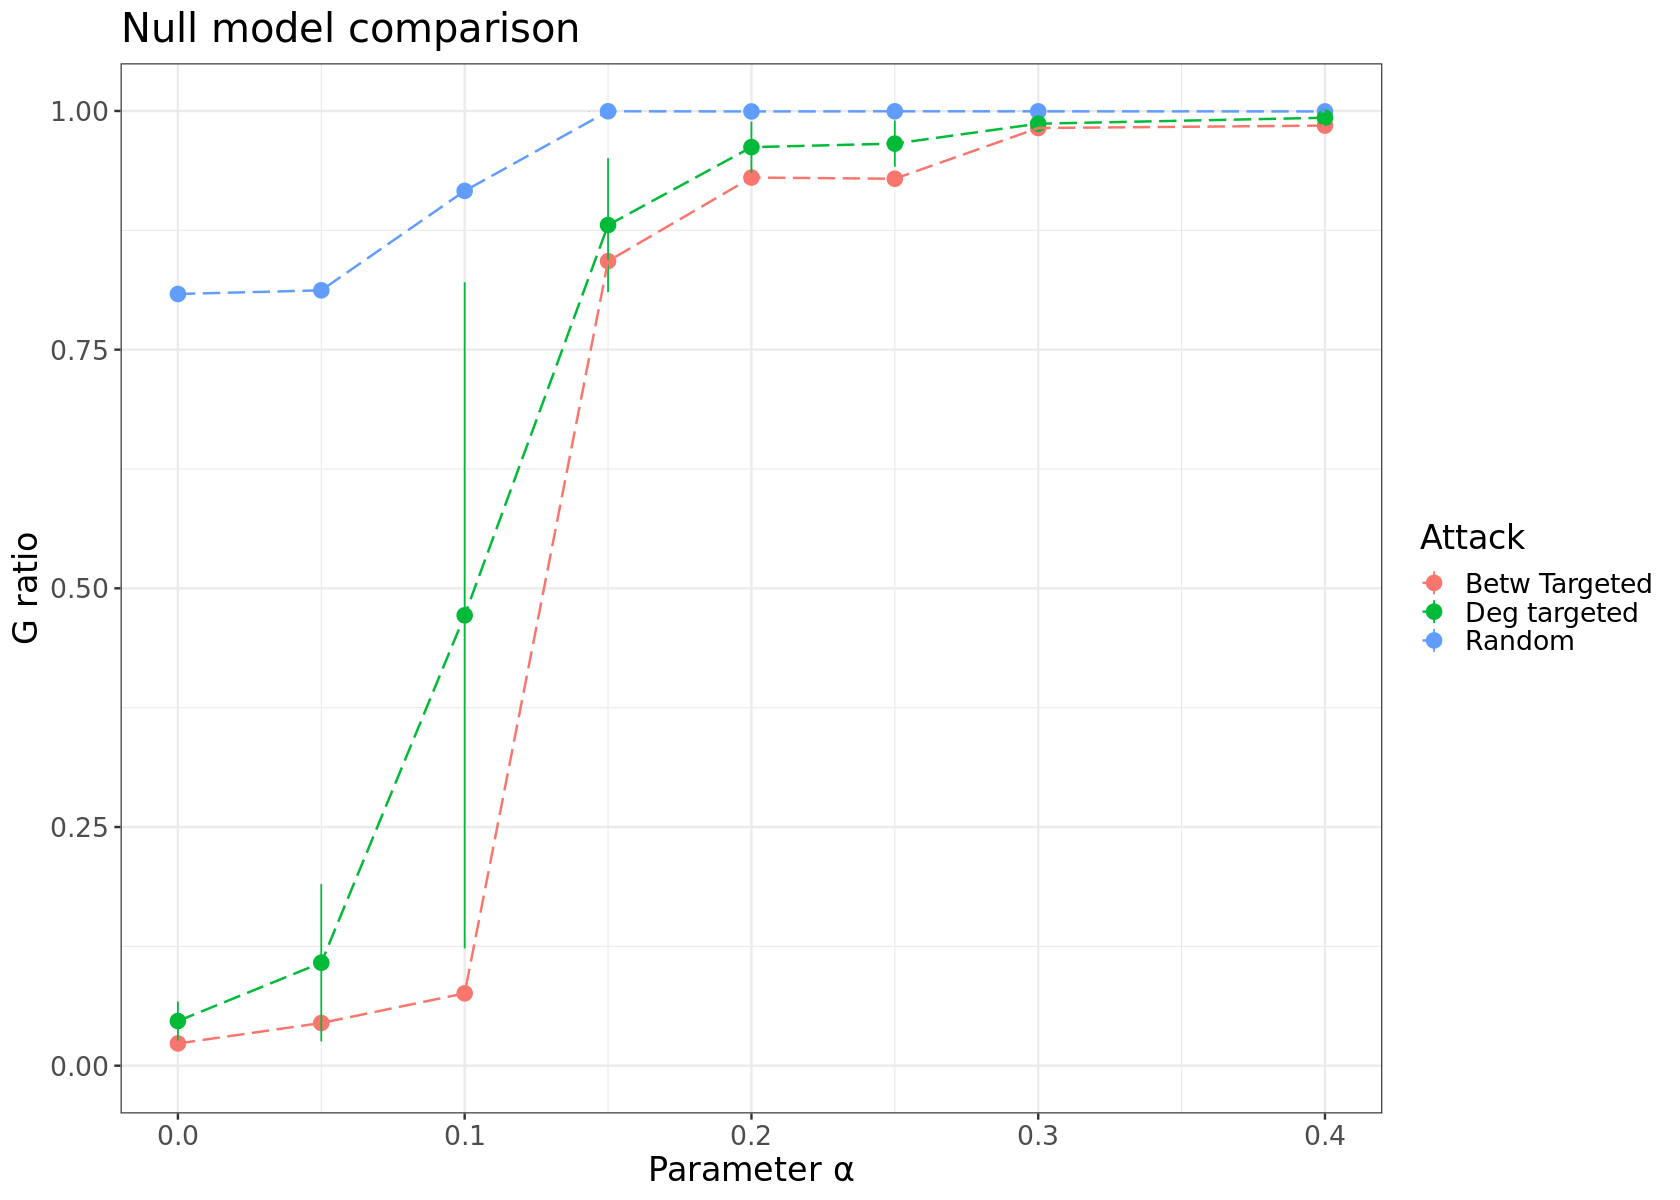

In [81]:
conf<-read.csv('power/null_config.csv')

plot_conf <- ggplot(conf) +
geom_point(aes(x = alpha,
               y = g_ratio,
               col = type),
           size = 4) +
geom_linerange(aes(x = alpha,
                   ymax = g_ratio + g_ratio_sd,
                   ymin = g_ratio - g_ratio_sd,
                   col = type),
               position = position_dodge(-0.02)) +
geom_line(aes(x = alpha,
              y = g_ratio,
              col = type),
          linewidth = 0.7,
          linetype=5) +
scale_x_continuous(limits = c(-0.05, 1)) +
labs(x = expression(paste("Parameter ", alpha)), 
     y = "G ratio",
     col = "Attack", title='Null model comparison') +
ylim(0, 1) +
xlim(0,0.4)+
theme_bw(base_size = 15) +
theme( text = element_text(size = 20))


plot_conf

# ggsave(plot = plot_conf, filename = 'power/plot_conf.pdf',  width = 10, height = 7,
#     scale = 0.75)

Warning message:
“Removed 11 rows containing missing values (`geom_segment()`).”


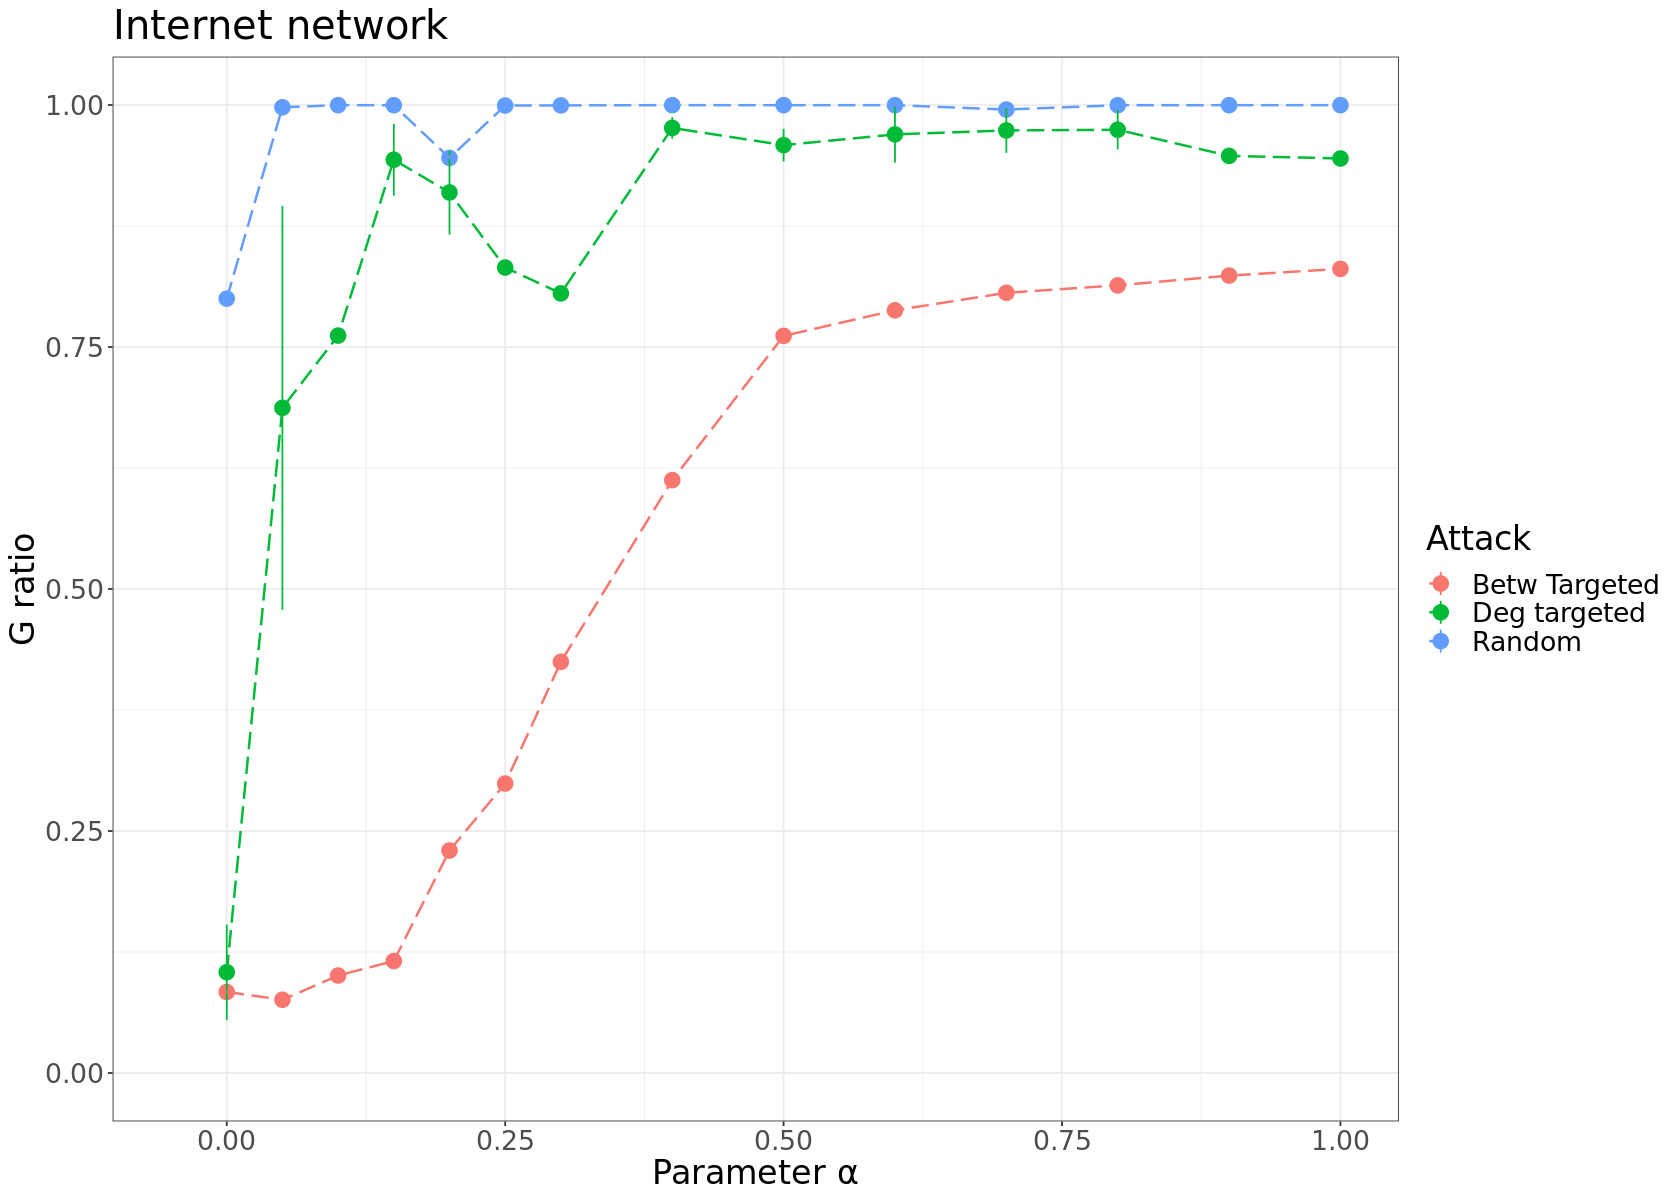

In [82]:
g_ratios_int<-read.csv('internet/plot_g.csv')

plot_conf_int <- ggplot(g_ratios_int) +
geom_point(aes(x = alpha,
               y = g_ratio,
               col = type),
           size = 4) +
geom_linerange(aes(x = alpha,
                   ymax = g_ratio + g_ratio_sd,
                   ymin = g_ratio - g_ratio_sd,
                   col = type)) +
geom_line(aes(x = alpha,
              y = g_ratio,
              col = type),
          linewidth = 0.7,
          linetype=5) +
scale_x_continuous(limits = c(-0.05, 1)) +
labs(x = expression(paste("Parameter ", alpha)),
     y = "G ratio", 
     col = "Attack", title='Internet network') + 
theme_bw() +
# theme(legend.position = c(0.75, 0.4),
#       legend.background = element_rect(size = 0.5, linetype = "solid",
#                                        colour = "black")) +
theme(text = element_text(size = 20))+ylim(0, 1)

plot_conf_int
# ggsave(plot = plot_conf, filename = 'internet/plot_g.pdf', width = 10, height = 7,
#     scale = 0.75)

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 15 rows containing missing values (`geom_segment()`).”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 23 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_line()`).”


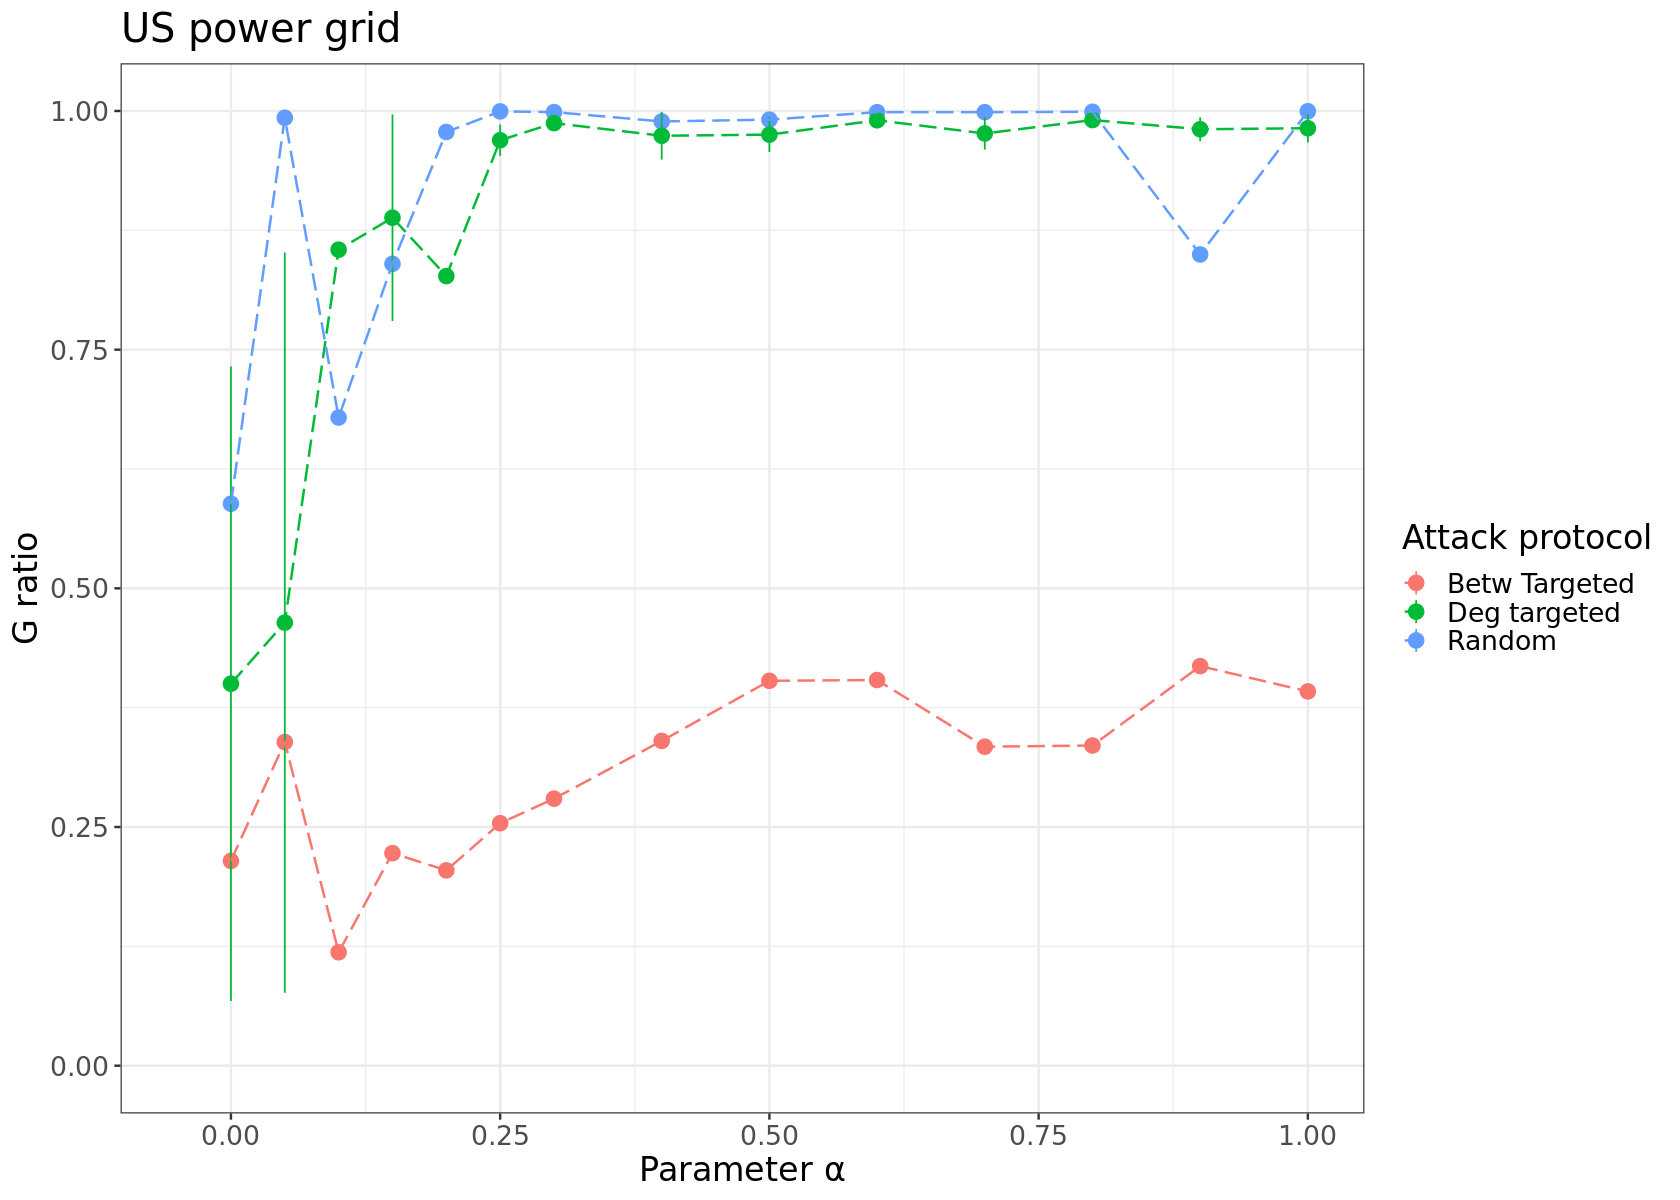

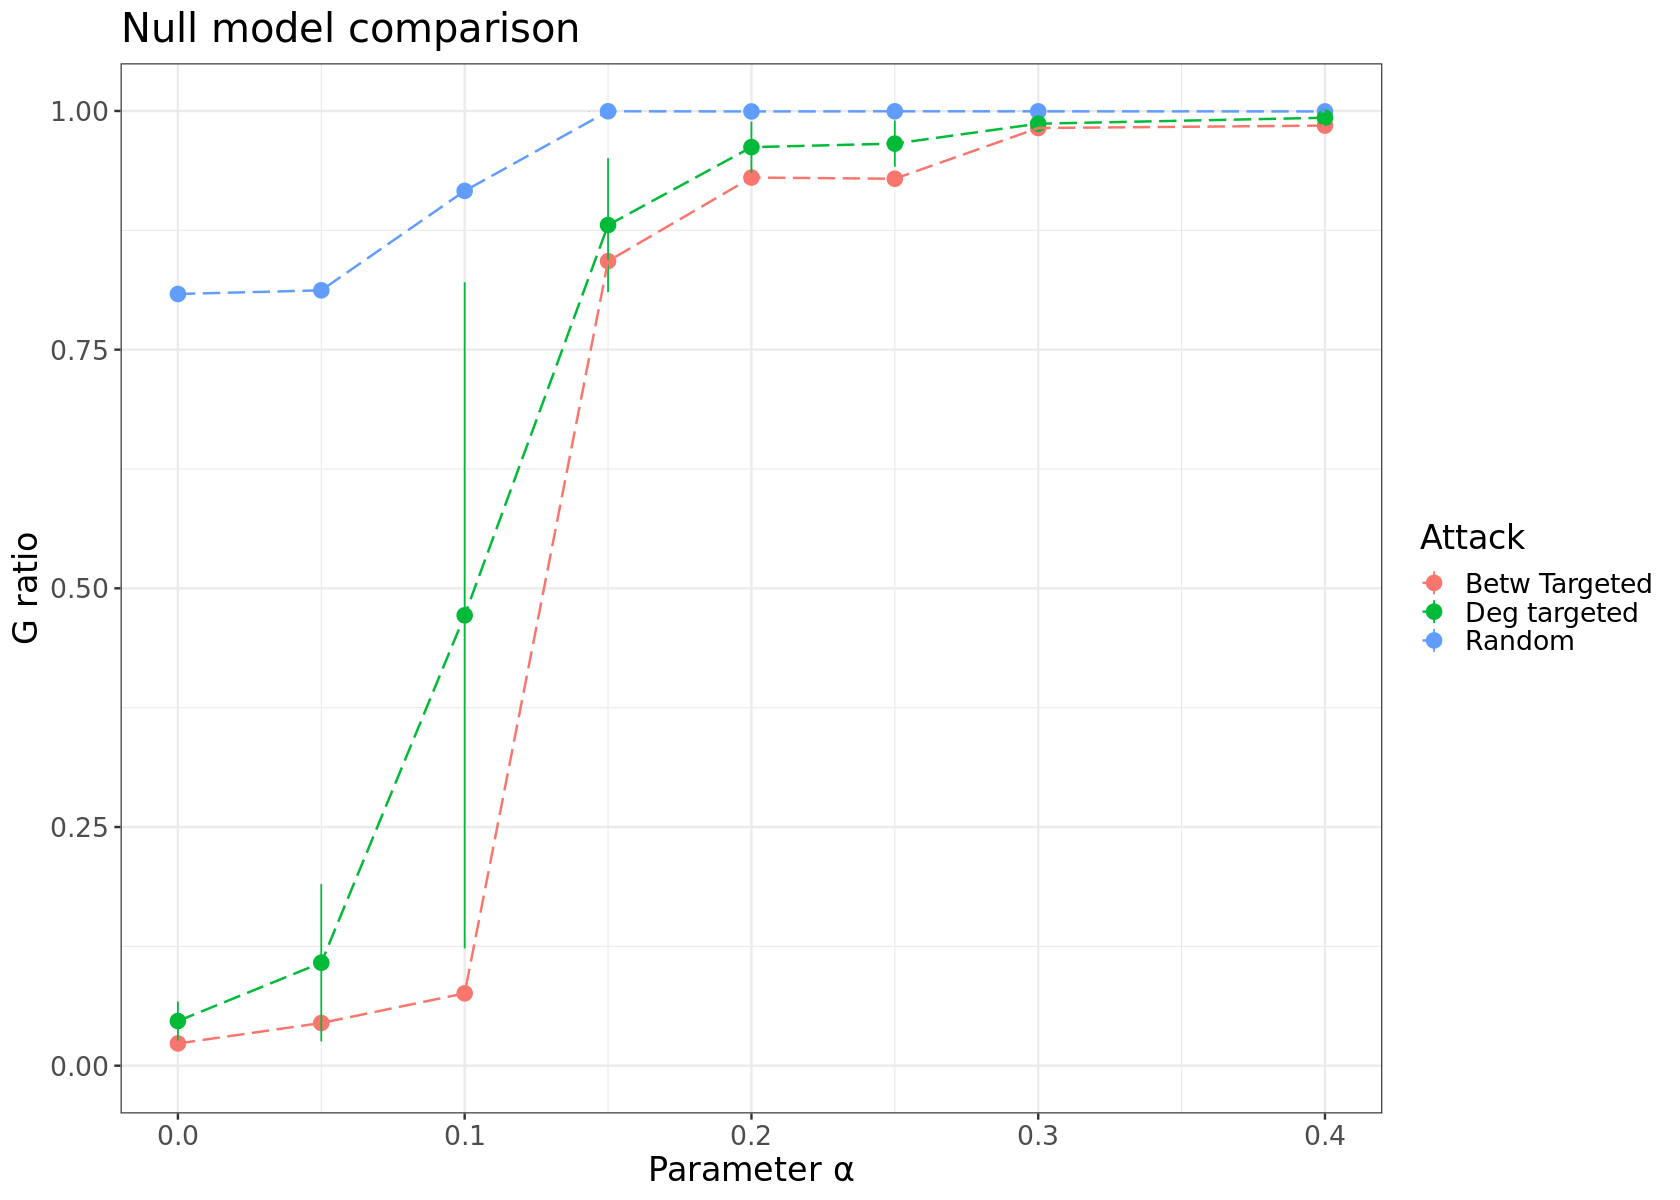

In [83]:
plot_conf_grd
plot_conf

In [77]:
library(ggpubr)

In [87]:
plot_all<-ggarrange(plot_conf_int, plot_conf_grd, plot_conf,common.legend = TRUE, legend = "bottom", ncol=3)

ggsave(plot = plot_all, filename = 'plot_all_emp.pdf', scale = 0.75, width = 30, height = 10)

Warning message:
“Removed 11 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_segment()`).”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 15 rows containing missing values (`geom_segment()`).”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 23 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 18 rows containing missing values (`geom_line()`).”


In [90]:
g

IGRAPH 78750c2 U--- 4941 6594 -- 
+ attr: cst_ids (v/n), load (v/n), capacity (v/n)
+ edges from 78750c2:
 [1]  7--  9  8--  9  9-- 10 10-- 11  6-- 14 13-- 14 14-- 15 14-- 16 15-- 17
[10] 15-- 18 19-- 20 20-- 21 15-- 30 34-- 35 35-- 36 36-- 37 37-- 38 37-- 39
[19] 37-- 40 42-- 43 37-- 48 45-- 48 46-- 48 47-- 48 11-- 51 22-- 52 25-- 54
[28] 26-- 59 42-- 59 59-- 60 60-- 61 10-- 62 32-- 63 64-- 69 65-- 69 66-- 69
[37] 36-- 70 67-- 70 69-- 70 68-- 71 70-- 71 73-- 74 10-- 76 49-- 76 77-- 78
[46] 79-- 80 80-- 81 82-- 83 14-- 84 72-- 87 77-- 87  5-- 89 56-- 89 88-- 89
[55] 88-- 90 89-- 91 74-- 92 12-- 95 27-- 95 44-- 95 93-- 95 94-- 95 95-- 96
[64] 35-- 98 41-- 98 29-- 99 43-- 99 58-- 99 75-- 99 83-- 99 99--101
+ ... omitted several edges

In [89]:
diameter(g,directed = F)

[1] 46